In [1]:
#pip install git+https://github.com/rjsteckel/dapi

In [3]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt 

from dapi.nhl import NHLClient

In [4]:
# Season goal difference 
def points_diff_ci(games, season1, season2):
    # total points scored
    A = games[games.season == season1][['homeScore', 'visitingScore']].sum(axis=1).to_numpy()
    B = games[games.season == season2][['homeScore', 'visitingScore']].sum(axis=1).to_numpy()

    sample_size = min(min(len(A), len(B)), 100)

    #data = [A[i] - B[i] for i in range(sample_size)]
    data = [B[i] - A[i] for i in range(sample_size)]
    res = st.bootstrap((data,), np.median, confidence_level=0.9, paired=False, method='basic',
                    vectorized=True, n_resamples=10000)
    return res.confidence_interval

In [9]:
def plot_goaldiff_ci(results):
    n = len(results)
    ci1 = np.array([r[2] for r in results])
    ci2 = np.array([r[3] for r in results])
    x = (ci2 + ci1) / 2  #midpoint
    y = list(range(0, n))

    err = x - ci1

    fig, ax = plt.subplots(figsize=(8, 12))
    ax.errorbar(x, y, xerr=err, fmt='o')

    labels = [f'{r[0]} vs. {r[1]}' for r in results]
    ax.set_yticks(list(range(len(labels))))
    ax.set_yticklabels(labels)
    ax.axvline(x=0, c='black', alpha=0.25)
    ax.grid()
    plt.title('Regular season total points scored');

In [5]:
client = NHLClient()
games = client.get_games()
games = games[games.gameType == 2]  # Regular season only

https://api.nhle.com/stats/rest/en/game


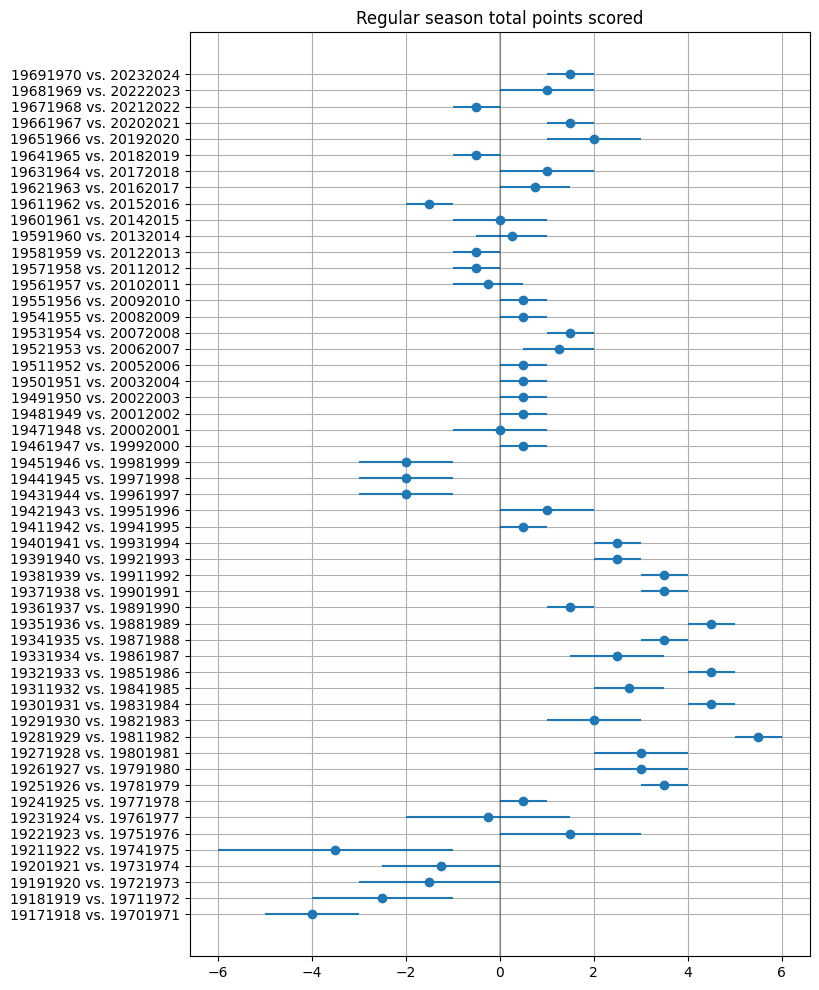

In [10]:
seasons = games.season.unique()
N = len(seasons)
mid = int(np.floor(N/2))
earlyseasons = seasons[:mid]
lateseasons = seasons[mid:]

results = []
for i in range(mid):
    s1 = earlyseasons[i]
    s2 = lateseasons[i]
    ci = points_diff_ci(games, s1, s2)
    
    results.append((s1, s2, ci[0], ci[1]))

plot_goaldiff_ci(results)